## 1. Import des librairies

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from string import punctuation
from bs4 import BeautifulSoup
from wordcloud import WordCloud

sns.set_style("whitegrid")
%matplotlib inline

## 2. Chargement des données

In [2]:
df = pd.read_csv("data/QueryResults.csv")

In [3]:
df

,title,body,tags
0,Recommended Fonts for Programming?,"<p>What fonts do you use for programming, and ...",<fonts><development-environment>
1,Why should I learn Lisp?,"<p>I really feel that I should learn <a href=""...",<functional-programming><lisp>
2,Restart node upon changing a file,<p>For someone who is coming from PHP backgrou...,<node.js>
3,100% Min Height CSS layout,<blockquote>\r\n <p>What's the best way to ma...,<html><css><xhtml>
4,How does Stack Overflow generate its SEO-frien...,"<p>What is a good complete <a href=""http://en....",<regex><language-agnostic><seo><friendly-url><...
...,...,...,...
16369,Can Selenium Webdriver open browser windows si...,<p>I have a selenium test suite that runs many...,<selenium><selenium-webdriver><webdriver><sele...
16370,How to symbolicate crash log Xcode?,<p>Xcode 5 organizer had a view which would li...,<ios><xcode>
16371,Spring Boot and multiple external configuratio...,<p>I have multiple property files that I want ...,<java><spring><config><spring-boot>
16372,Java's final vs. C++'s const,"<p>The <a href=""http://triton.towson.edu/~mzim...",<java><c++><const><final>


## 3. Prétraitement des données

### 3.1. Gestion des doublons

In [4]:
print(df.duplicated(subset=["title"]).sum())
df = df.drop_duplicates(subset=["title"])

1


### 3.2. Modification des tags

In [5]:
def rewrite_tags(text):
    text = re.sub("<", "", text)
    text = re.sub(">", " ", text)
    return text

In [6]:
df["tags"] = df["tags"].apply(lambda x: rewrite_tags(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 4. Analyse exploratoire basique sur les tags

### 4.1. Fréquence de tag_count

In [7]:
df["tag_count"] = df["tags"].apply(lambda x: len(x.split()))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df["tag_count"].value_counts()

3    4862
2    3912
4    3779
5    2658
1    1162
Name: tag_count, dtype: int64

In [9]:
print( "Nombre de tag maximum pour une question: ", df["tag_count"].max())
print( "Nombre de tag minimum pour une question: ", df["tag_count"].min())
print( "Nombre de tag moyen pour une question: ", df["tag_count"].mean())

Nombre de tag maximum pour une question:  5
Nombre de tag minimum pour une question:  1
Nombre de tag moyen pour une question:  3.174616747083613


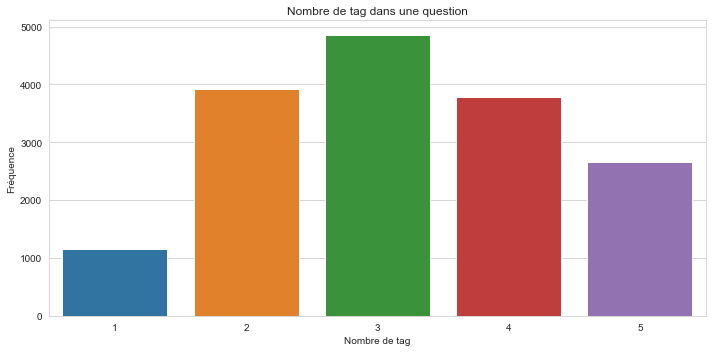

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(df["tag_count"])
plt.title("Nombre de tag dans une question")
plt.xlabel("Nombre de tag")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

Observations:
    1. Nombre maximum de tag pour une question : 5
    2. Nombre minimum de tag pour une question : 1
    3. Nombre moyen de tag pour une question: 3.17
    4. La plupart des question ont entre 2 et 4 tags

### 4.2. Nombre total de tags unique

In [11]:
countVectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = countVectorizer.fit_transform(df['tags'])

In [12]:
print("Nombre de questions : ", tag_bow.shape[0])
print("Nombre de tag unique : ", tag_bow.shape[1])

Nombre de questions :  16373
Nombre de tag unique :  6159


In [13]:
tags = countVectorizer.get_feature_names()
print("Quelques tags : ", tags[:10])

Quelques tags :  ['.a', '.bash-profile', '.d.ts', '.htaccess', '.net', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.5']


### 4.3. Fréquence de chaque tags

In [14]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [15]:
list = []
for key, value in tag_to_count_map.items():
    list.append([key, value])

In [16]:
tag_df = pd.DataFrame(list, columns=['tags', 'counts'])
tag_df.head()

,tags,counts
0,.a,1
1,.bash-profile,1
2,.d.ts,1
3,.htaccess,22
4,.net,459


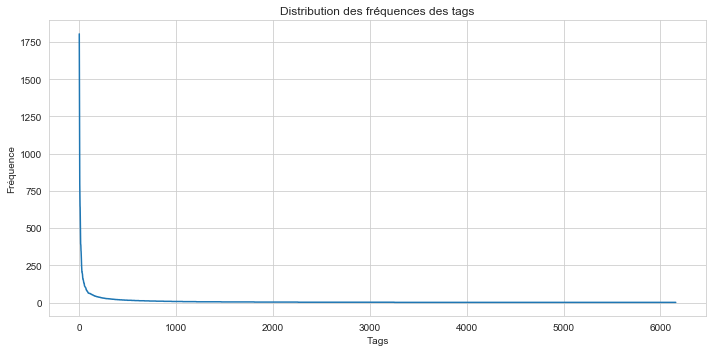

In [17]:
tag_df_sorted = tag_df.sort_values(['counts'], ascending=False)
plt.figure(figsize=(10, 5))
plt.plot(tag_df_sorted['counts'].values)
plt.title("Distribution des fréquences des tags")
plt.xlabel("Tags")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

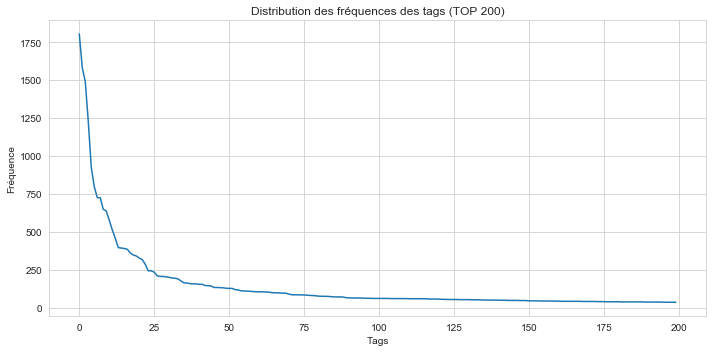

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(tag_df_sorted['counts'][0:200].values)
plt.title("Distribution des fréquences des tags (TOP 200)")
plt.xlabel("Tags")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

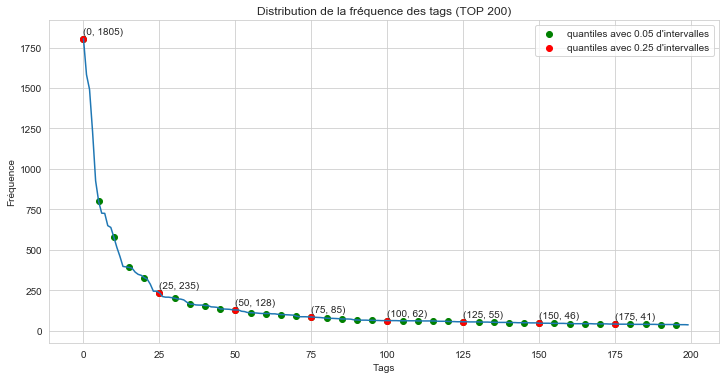

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(tag_df_sorted['counts'][0:200].values)
plt.scatter(x=np.arange(0, 200, 5), y=tag_df_sorted['counts'][0:200:5], c='g', label="quantiles avec 0.05 d'intervalles")
plt.scatter(x=np.arange(0, 200, 25), y=tag_df_sorted['counts'][0:200:25], c='r', label="quantiles avec 0.25 d'intervalles")
for x, y in zip(np.arange(0, 200, 25), tag_df_sorted['counts'][0:200:25]):
    plt.annotate(s="({}, {})".format(x, y), xy=(x,y), xytext=(x-0.01, y+30))
plt.tight_layout()
plt.title("Distribution de la fréquence des tags (TOP 200)")
plt.xlabel("Tags")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

In [20]:
print("{} tags sont utilisés plus de 100 fois.".format(tag_df_sorted[tag_df_sorted["counts"] > 100].shape[0]))
print("{} tags sont utilisés plus de 500 fois.".format(tag_df_sorted[tag_df_sorted["counts"] > 500].shape[0]))

65 tags sont utilisés plus de 100 fois.
12 tags sont utilisés plus de 500 fois.


In [21]:
tag_df_sorted.head()

,tags,counts
2942,javascript,1805
4350,python,1582
2914,java,1491
142,android,1229
828,c#,926


Observations:
    1. 65 tags sont utilisés plus de 100 fois.
    2. 12 tags sont utilisés plus de 500 fois.
    3. javascript est le tag plus utilisés avec 1805 fois.

### 4.4. Carte des mots pour les tags les plus fréquents

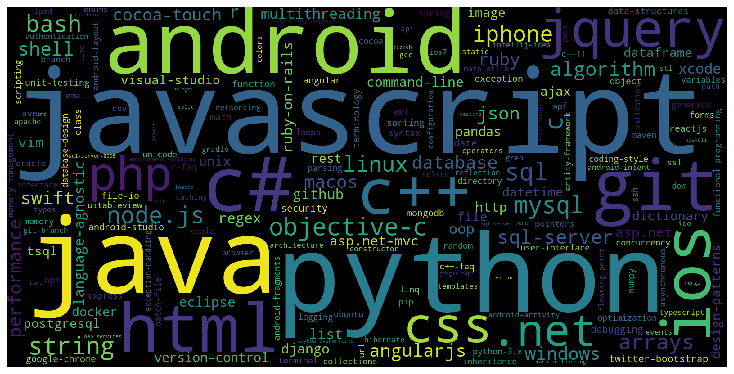

In [22]:
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600, height=800,).generate_from_frequencies(tupl)
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Observations:
    1. "javascript", "java", "python", "android", "jquery", "html", "git" et "C#" sont les tags les plus fréquents.

In [23]:
tag_df_sorted.head(20)["tags"]

2942     javascript
4350         python
2914           java
142         android
828              c#
2230            git
2546           html
2834            ios
833             c++
2989         jquery
1277            css
4087            php
4              .net
3837    objective-c
5056            sql
5204         string
827               c
3596          mysql
3709        node.js
657            bash
Name: tags, dtype: object

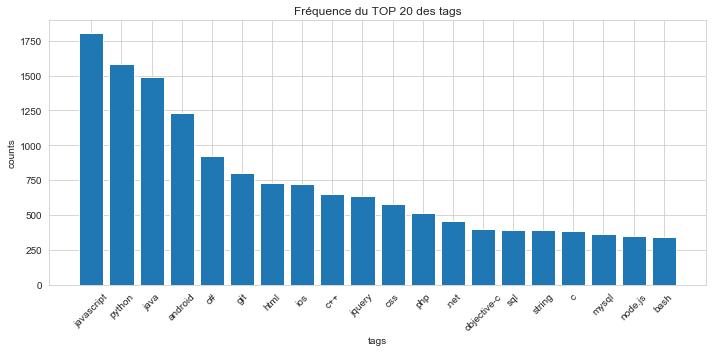

In [24]:
i=np.arange(20)
plt.figure(figsize=(10, 5))
plt.bar(tag_df_sorted.head(20)["tags"], tag_df_sorted.head(20)["counts"])
plt.title("Fréquence du TOP 20 des tags")
plt.xlabel("tags")
plt.ylabel("counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df.drop(columns=["tag_count"], inplace=True)

C:\Users\Julien\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


On garde seulement les 200 tags les plus utilisés

In [26]:
df["tags"] = df["tags"].apply(lambda x: x.split())

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
flat_list = [item for sublist in df["tags"].values for item in sublist]

keywords = nltk.FreqDist(flat_list)
keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(200)
tags_features = [word[0] for word in frequencies_words]

In [28]:
tags_features

['javascript',
 'python',
 'java',
 'android',
 'c#',
 'git',
 'html',
 'ios',
 'c++',
 'jquery',
 'css',
 'php',
 '.net',
 'objective-c',
 'sql',
 'string',
 'c',
 'mysql',
 'node.js',
 'bash',
 'iphone',
 'linux',
 'arrays',
 'algorithm',
 'sql-server',
 'shell',
 'performance',
 'windows',
 'angularjs',
 'macos',
 'json',
 'swift',
 'database',
 'ruby',
 'r',
 'multithreading',
 'cocoa-touch',
 'xcode',
 'language-agnostic',
 'oop',
 'regex',
 'ruby-on-rails',
 'list',
 'github',
 'vim',
 'django',
 'asp.net-mvc',
 'asp.net',
 'command-line',
 'http',
 'unix',
 'eclipse',
 'version-control',
 'pandas',
 'visual-studio',
 'ajax',
 'docker',
 'file',
 'dictionary',
 'postgresql',
 'rest',
 'image',
 'design-patterns',
 'dataframe',
 'datetime',
 'twitter-bootstrap',
 'tsql',
 'date',
 'security',
 'debugging',
 'object',
 'syntax',
 'sorting',
 'google-chrome',
 'exception',
 'function',
 'npm',
 'spring',
 'unit-testing',
 'terminology',
 'reactjs',
 'math',
 'mongodb',
 'xml',
 'cla

In [29]:
import pickle

with open('webapp/model/tag_features.pkl', 'wb') as file:
    pickle.dump(tags_features, file)

In [30]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [31]:
df["tags"] = df["tags"].apply(lambda x: most_common(x))
df["tags"] = df["tags"].apply(lambda x: x if len(x) > 0 else None)

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
df.dropna(subset=["tags"], inplace=True)

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df

,title,body,tags
1,Why should I learn Lisp?,"<p>I really feel that I should learn <a href=""...",[functional-programming]
2,Restart node upon changing a file,<p>For someone who is coming from PHP backgrou...,[node.js]
3,100% Min Height CSS layout,<blockquote>\r\n <p>What's the best way to ma...,"[html, css]"
4,How does Stack Overflow generate its SEO-frien...,"<p>What is a good complete <a href=""http://en....","[regex, language-agnostic]"
5,Get OS-level system information,<p>I'm currently building a Java app that coul...,"[java, memory]"
...,...,...,...
16368,What is the difference between an interface an...,<p>What exactly is the difference between an i...,"[oop, interface]"
16370,How to symbolicate crash log Xcode?,<p>Xcode 5 organizer had a view which would li...,"[ios, xcode]"
16371,Spring Boot and multiple external configuratio...,<p>I have multiple property files that I want ...,"[java, spring]"
16372,Java's final vs. C++'s const,"<p>The <a href=""http://triton.towson.edu/~mzim...","[java, c++]"


## 5. Prétraitement du texte

### 5.1. Suppression du code HTML

In [34]:
def clean_text_in_code(text):
    soup = BeautifulSoup(text)
    codetags = soup.find_all('code')
    for codetag in codetags:
        codetag.extract()
    return soup.get_text()

In [35]:
df["body"] = df["body"].apply(lambda x: clean_text_in_code(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [37]:
df["title"] = df["title"].apply(lambda x: clean_text(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
df["document"] = df["title"] + " " + df["body"]
df.drop(columns=["title", "body"], inplace=True)

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 5.2. Suppression de la ponctuation

In [39]:
token = ToktokTokenizer()

In [40]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text):
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punctuation))
    remove_punctuation = str.maketrans(' ', ' ', punctuation)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
    filtered_list = strip_list_noempty(punctuation_filtered)
    
    return ' '.join(map(str, filtered_list))

In [41]:
clean_punct(df["document"][2])

'restart node upon changing a file For someone who is coming from PHP background the process of killing node and starting it again after every code change seems very tedious Is there any flag when starting a script with node to automatically restart node when code change is saved'

In [42]:
df["document"] = df["document"].apply(lambda x: clean_punct(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 5.3. Suppression des stop words

In [43]:
def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words = token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [44]:
stopWordsRemove(df["document"][2])

'restart node upon changing file For someone coming PHP background process killing node starting every code change seems tedious Is flag starting script node automatically restart node code change saved'

In [45]:
df["document"] = df["document"].apply(lambda x: stopWordsRemove(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 5.4. Lemmatisation

In [46]:
lemma = WordNetLemmatizer()
def lemitizeWords(text):
    words = token.tokenize(text)
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

In [47]:
lemitizeWords(df["document"][2])

'restart node upon change file For someone come PHP background process kill node start every code change seem tedious Is flag start script node automatically restart node code change save'

In [48]:
df["document"] = df["document"].apply(lambda x: lemitizeWords(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 5.5. Stemmatisation

In [49]:
stemmer = LancasterStemmer()
def stemmitizeWords(text):
    words = token.tokenize(text)
    listStem = []
    for w in words:
        x = stemmer.stem(w)
        listStem.append(x)
    return ' '.join(map(str, listStem))

In [50]:
stemmitizeWords(df["document"][2])

'restart nod upon chang fil for someon com php background process kil nod start every cod chang seem tedy is flag start script nod autom restart nod cod chang sav'

La stemmatisation coupe trop nos mots, nous n'allons donc pas l'utilisés

## 6. Analyse exploratoire basique sur les documents

### 6.1. Fréquence de words_count

In [51]:
df["words_count"] = df["document"].apply(lambda x: len(x.split()))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
df = df[df["words_count"] >= 10]

In [53]:
df["words_count"].value_counts()

23     339
31     313
27     310
24     309
22     304
      ... 
371      1
355      1
331      1
315      1
927      1
Name: words_count, Length: 354, dtype: int64

In [54]:
print( "Nombre de mots maximum pour une question: ", df["words_count"].max())
print( "Nombre de mots minimum pour une question: ", df["words_count"].min())
print( "Nombre de mots moyen pour une question: ", df["words_count"].mean())

Nombre de mots maximum pour une question:  1443
Nombre de mots minimum pour une question:  10
Nombre de mots moyen pour une question:  51.98017331932773


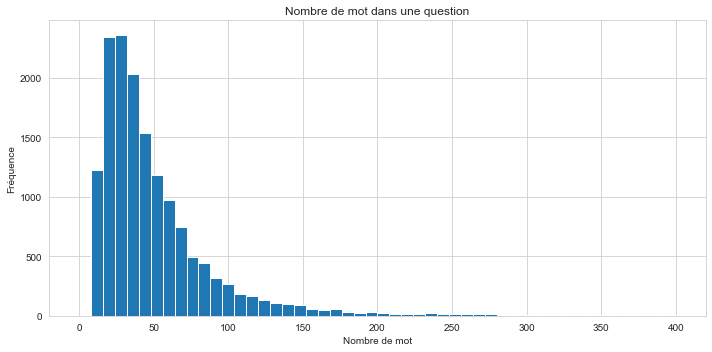

In [55]:
plt.figure(figsize=(10, 5))
plt.hist(df["words_count"], bins=50, range=(0,400))
plt.title("Nombre de mot dans une question")
plt.xlabel("Nombre de mot")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

### 6.2. Nombre total de mot unique

Je décide de supprimer certains des mots les plus courant qui sont utilisés trop de fois

In [56]:
countVectorizer = CountVectorizer(tokenizer = lambda x: x.split(), max_df=15230, min_df=5)
word_bow = countVectorizer.fit_transform(df['document'])

In [57]:
print("Nombre de questions : ", word_bow.shape[0])
print("Nombre de mot unique : ", word_bow.shape[1])

Nombre de questions :  15232
Nombre de mot unique :  5665


In [58]:
words = countVectorizer.get_feature_names()

### 6.3. Fréquence de chaque mots

In [59]:
freq = word_bow.sum(axis=0).A1
word_to_count_map = dict(zip(words, freq))

In [60]:
list = []
for key, value in word_to_count_map.items():
    list.append([key, value])

In [61]:
word_df = pd.DataFrame(list, columns=['word', 'counts'])
word_df.head()

,word,counts
0,.net,125
1,0,314
2,00,34
3,01,16
4,0100,6


In [62]:
word_df.sort_values(['counts'], ascending=False).head(20)

,word,counts
2411,i,53987
5310,use,14117
2901,like,6364
1956,file,6145
2143,get,6084
5468,way,5071
5460,want,4958
982,code,4701
5588,would,4678
5570,work,4665


In [63]:
words_to_remove = word_df.sort_values(['counts'], ascending=False).head(19)["word"]

In [64]:
indexes = word_df.sort_values(['counts'], ascending=False).head(19).index
word_df.drop(indexes, inplace=True)

In [65]:
def remove_common_word(text, words_to_remove):
    for word in words_to_remove:
        text = text.lower()
        text = re.sub(r'\b('+word+r')\b', '', text)
        text = " ".join(text.split())
    return text

In [66]:
df["document"] = df["document"].apply(lambda x: remove_common_word(x, words_to_remove))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
countVectorizer = CountVectorizer(tokenizer = lambda x: x.split(), max_df=15230, min_df=5)
word_bow = countVectorizer.fit_transform(df['document'])
words = countVectorizer.get_feature_names()
freq = word_bow.sum(axis=0).A1
word_to_count_map = dict(zip(words, freq))

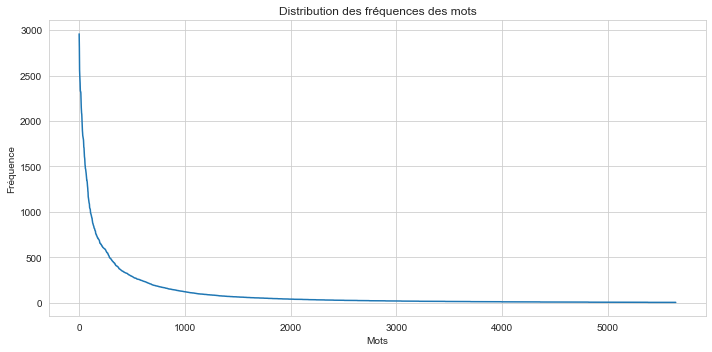

In [68]:
word_df_sorted = word_df.sort_values(['counts'], ascending=False)
plt.figure(figsize=(10, 5))
plt.plot(word_df_sorted['counts'].values)
plt.title("Distribution des fréquences des mots")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

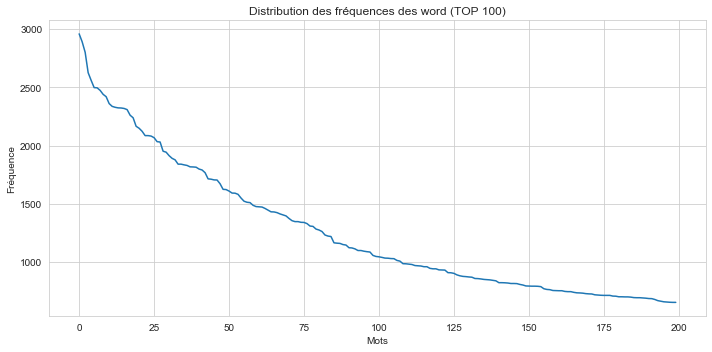

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(word_df_sorted['counts'][0:200].values)
plt.title("Distribution des fréquences des word (TOP 100)")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

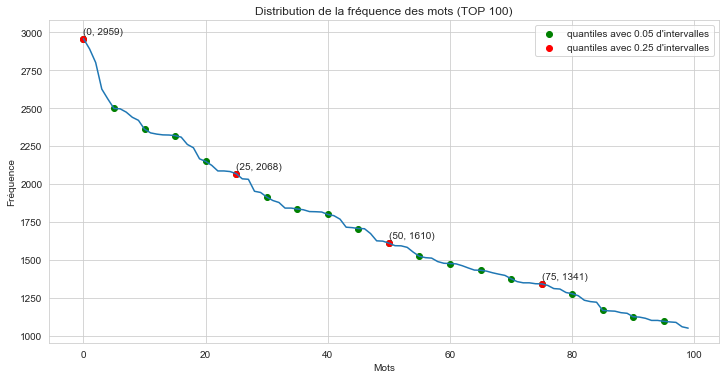

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(word_df_sorted['counts'][0:100].values)
plt.scatter(x=np.arange(0, 100, 5), y=word_df_sorted['counts'][0:100:5], c='g', label="quantiles avec 0.05 d'intervalles")
plt.scatter(x=np.arange(0, 100, 25), y=word_df_sorted['counts'][0:100:25], c='r', label="quantiles avec 0.25 d'intervalles")
for x, y in zip(np.arange(0, 100, 25), word_df_sorted['counts'][0:100:25]):
    plt.annotate(s="({}, {})".format(x, y), xy=(x,y), xytext=(x-0.01, y+30))
plt.tight_layout()
plt.title("Distribution de la fréquence des mots (TOP 100)")
plt.xlabel("Mots")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

In [71]:
print("{} mots sont utilisés plus de 100 fois.".format(word_df_sorted[word_df_sorted["counts"] > 100].shape[0]))
print("{} mots sont utilisés plus de 1000 fois.".format(word_df_sorted[word_df_sorted["counts"] > 1000].shape[0]))

1123 mots sont utilisés plus de 100 fois.
108 mots sont utilisés plus de 1000 fois.


In [72]:
word_df_sorted.head(10)

,word,counts
3018,make,2959
4302,run,2891
1245,create,2801
2096,function,2626
2020,follow,2560
881,change,2498
1805,example,2496
1765,error,2474
4762,string,2440
1319,data,2420


Observations:
    1. 1123 mots sont utilisés plus de 100 fois.
    2. 108 tags sont utilisés plus de 1000 fois.
    3. "make" est le mot plus utilisés avec 2959 fois.

### 6.4. Carte des mots pour les mots les plus fréquents

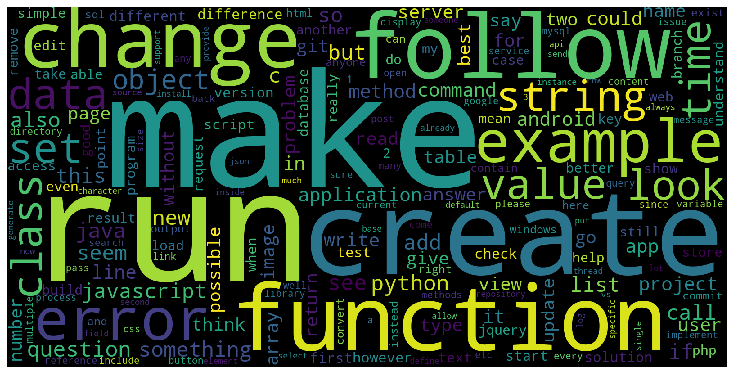

In [73]:
tupl = dict(word_to_count_map.items())
word_cloud = WordCloud(width=1600, height=800,).generate_from_frequencies(tupl)
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Observations:
    1. "make", "create", "run", "function", "follow", "example" sont les mots les plus fréquents.

In [74]:
word_df_sorted.head(20)["word"]

3018        make
4302         run
1245      create
2096    function
2020      follow
881       change
1805     example
1765       error
4762      string
1319        data
5356       value
4459         set
932        class
5033        time
2966        look
3413      object
3975    question
4400         see
3962      python
5001        this
Name: word, dtype: object

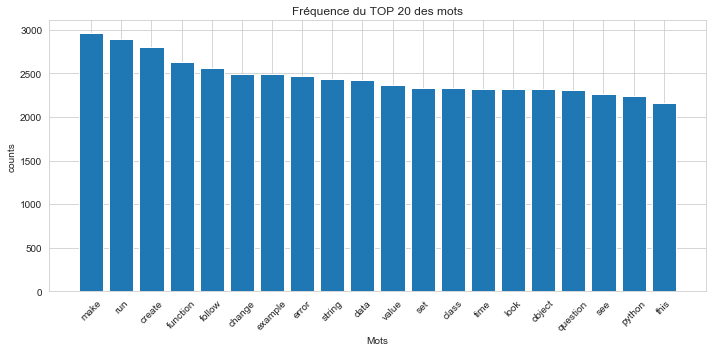

In [75]:
i=np.arange(20)
plt.figure(figsize=(10, 5))
plt.bar(word_df_sorted.head(20)["word"], word_df_sorted.head(20)["counts"])
plt.title("Fréquence du TOP 20 des mots")
plt.xlabel("Mots")
plt.ylabel("counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
df.drop(columns=["words_count"], inplace=True)

C:\Users\Julien\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## 7. - Enregistrement du nouveau jeu de données

In [77]:
df["tags"] = df["tags"].apply(lambda x: ' '.join(x))

C:\Users\Julien\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
df.to_csv("data/clean.csv")